In [1]:
import pandas as pd
from pathlib import Path # type: ignore
from freyja_plot import FreyjaPlotter
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
if (module_path:=str(Path(".").absolute().resolve().parent)) not in sys.path:
    sys.path.insert(0, module_path)
from sample_info import renameSamples, summary_dict, expected, platforms, platform_renames, backgrounds, get_freyja_aggregate_file

In [2]:
file_map = {}
for platform in platforms:
    for background in backgrounds:
        file_map[str(get_freyja_aggregate_file(platform, background))] = f"{platform_renames[platform]}: {background.upper()}"
file_map[str(expected)] = "Expected"
plotter = FreyjaPlotter(file_map=file_map,summary_dict=summary_dict)
plotter = renameSamples(plotter)
df = plotter.summarized_freyja_df.rename(columns={"Sample name":"sample","abundances":"abundance","scheme":"batch","lineages":"lineage"})
df

,sample,lineage,abundance,batch
565,0,A,0.007881,Illumina (minimap2): NWRB
948,0,Wuhan-hu-1,0.333146,Illumina (bwa): PWRB
947,0,Other,0.666292,Illumina (bwa): PWRB
751,0,Wuhan-hu-1,0.166553,Illumina (bwa): WB
750,0,Other,0.832767,Illumina (bwa): WB
...,...,...,...,...
1776,o5-3,BA.5.X,0.980580,ONT: PWRB
1777,o5-3,BA.4.X,0.002968,ONT: PWRB
298,o5-3,BA.5.X,0.999757,Illumina (unpaired): PWRB
1084,o5-3,BA.5.X,0.998984,CG: WB


In [3]:
lineages = set(df["lineage"].unique())
l2_batches = set(df["batch"].unique())
l2s = []

# for each sample, calculate l2 array for the batches
for sample in set(df["sample"].unique()) - {None}:
    sample_df = df.loc[df['sample'] == sample, ('batch', 'lineage', 'abundance')]
    # print(sample_df)
    
    pivoted_sample_df = sample_df.pivot_table(index='lineage', columns='batch', values='abundance').fillna(0).T
    # print(pivoted_sample_df)

    # for any missing batch, append 0-abundance df to bottom
    dfs2append = []
    missing_batches = l2_batches - set(pivoted_sample_df.index.unique())
    # print(f"{sample} missing batches: {missing_batches}")
    for batch in missing_batches:
        dfs2append.append(
            pd.DataFrame({lin:[0] for lin in lineages},index=[batch])
        )
    if dfs2append:
        pivoted_sample_df = pd.concat([pivoted_sample_df]+dfs2append).fillna(0)
    pivoted_sample_df = pivoted_sample_df.reindex(["Expected"] + [x for x in pivoted_sample_df.index if x != "Expected"])

    Y = squareform(pdist(pivoted_sample_df, 'euclidean'))
    l2s.append(Y)

# get order of batches, as they appear in the l2s
l2_index = pivoted_sample_df.index

# combine l2 results into a single condensed array
l2s_stacked = np.stack(l2s)
l2m = np.median(l2s_stacked, axis=0)
l2m

array([[0.00000000e+00, 3.88131554e-02, 5.73704127e-02, 4.80192031e-02,
        1.37669577e-01, 5.00624530e-03, 5.72105965e-02, 1.38357894e-01,
        1.03182435e-02, 5.69337000e-03, 3.53637788e-02, 5.17742651e-02,
        5.81543752e-02, 2.55057583e-02, 1.88520125e-01, 1.76742502e-01],
       [3.88131554e-02, 0.00000000e+00, 7.23127988e-03, 7.92932209e-03,
        1.68791808e-02, 1.73322582e-02, 4.40698946e-02, 1.69420685e-02,
        1.78936806e-02, 3.83619342e-02, 6.54535839e-03, 1.52716170e-02,
        2.42030954e-02, 2.25616957e-02, 1.47427572e-01, 1.96887776e-01],
       [5.73704127e-02, 7.23127988e-03, 0.00000000e+00, 2.16917239e-02,
        2.54784014e-02, 6.68049273e-03, 7.05536028e-02, 2.54784520e-02,
        2.63795214e-02, 5.44101824e-02, 6.84628706e-03, 4.58953005e-03,
        2.91884470e-02, 2.12478200e-02, 1.63538646e-01, 1.88560999e-01],
       [4.80192031e-02, 7.92932209e-03, 2.16917239e-02, 0.00000000e+00,
        4.71480914e-02, 4.47585736e-02, 5.62426609e-02, 4.714

In [4]:
len(file_map)

16

In [5]:
expected_vs_batches = list(l2m[0])
if len(set(expected_vs_batches)) < len(expected_vs_batches):
    print(expected_vs_batches)
    raise Exception("Can't sort things when any values are duplicated")
idx = [expected_vs_batches.index(x) for x in sorted(expected_vs_batches)]
l2m_clustered = l2m[idx,:]
l2m_clustered = l2m_clustered[:,idx]
l2m_clustered

array([[0.00000000e+00, 5.00624530e-03, 5.69337000e-03, 1.03182435e-02,
        2.55057583e-02, 3.53637788e-02, 3.88131554e-02, 4.80192031e-02,
        5.17742651e-02, 5.72105965e-02, 5.73704127e-02, 5.81543752e-02,
        1.37669577e-01, 1.38357894e-01, 1.76742502e-01, 1.88520125e-01],
       [5.00624530e-03, 0.00000000e+00, 9.68131406e-03, 1.07000000e-06,
        2.02148098e-02, 1.68722129e-02, 1.73322582e-02, 4.47585736e-02,
        2.18477562e-02, 5.69973355e-02, 6.68049273e-03, 4.73182696e-02,
        1.03174639e-02, 3.65912372e-03, 2.73712054e-01, 1.98018189e-01],
       [5.69337000e-03, 9.68131406e-03, 0.00000000e+00, 5.69974568e-02,
        2.01558070e-02, 3.15724906e-02, 3.83619342e-02, 4.75940650e-02,
        5.61676141e-02, 9.49000000e-05, 5.44101824e-02, 5.65903458e-02,
        3.97552000e-03, 3.97548000e-03, 2.91739741e-01, 2.33984197e-01],
       [1.03182435e-02, 1.07000000e-06, 5.69974568e-02, 0.00000000e+00,
        2.23876261e-02, 2.71818231e-02, 1.78936806e-02, 4.475

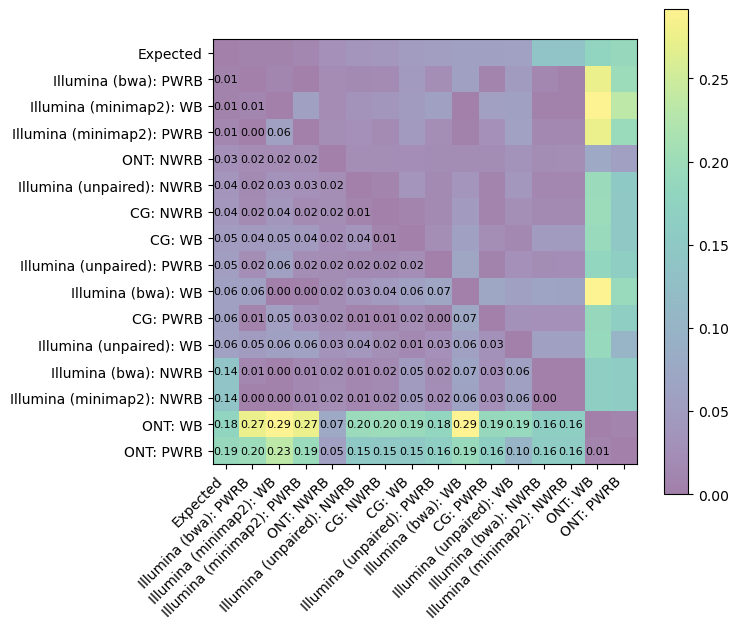

In [6]:
# plot
fig, (ax) = plt.subplots(1, 1, figsize=(6.85, 9))

N = len(l2_index)

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

for (j,i), label in np.ndenumerate(l2m_clustered):
    if j > i:
        ax.text(i, j,'{:.2f}'.format(label), ha='center', va='center', fontsize=8)

cmap = matplotlib.colormaps.get_cmap('viridis') # jet doesn't have white color
cmap.set_bad('w') # default value is 'k'

im = ax.imshow(l2m_clustered, alpha=0.5, cmap=cmap, aspect='equal')
fig.colorbar(im, ax=ax, shrink=0.7)

ax.set_xticks(np.arange(N))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(l2_index[idx], rotation=45, ha='right')
ax.set_yticklabels(l2_index[idx])

fig.savefig('L2_matrix_artic.tiff', dpi=600, bbox_inches='tight')
fig.savefig('L2_matrix_artic.png', bbox_inches='tight')